# FWI Wildfire Workflow - Risk

Click [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/CLIMAAX/FIRE/main?labpath=FWI_Risk_Assessment.ipynb) to launch the workflow on Binder! Not all functionalities might be available on Binder due to limited memory.

In this workflow we will produce an assessment of wildfire development risk based on the seasonal Fire Weather Index (FWI) and a range of parameters linked to wildfire vulnerability. On one hand, this workflow provides a simple tool to assess which areas of a region have the most suitable setting for wildfire development based on climatic conditions and fuel availability. On the other, it informs the users on which areas are the most vulnerable to wildfire from a human, economic and environmental point of view. Synthetizing infromation about wildfire danger and vulnerability, the workflow finally produces an assessment of wildfire risk, pointing out which areas should be prioritised by adaptation measures.

### Risk Assessment Methodology

Wildfire risk is defined following the approach of the European Forest Fire Information System (EFFIS), characterizing it as the combination of wildfire danger and vulnerability (Jacome Felix Oom, 2022). A full explaination of the risk index calculation methodology can be found in the [description](FWI_Risk_Description.md) document.

In summary, wildfire danger is first calculated as the combination of climatic danger, here represented by the seasonal FWI, and fuel  availability given by the abundance of burnable vegetation. The two danger indicators are normalised and averaged to produce a spatialised fire danger index. This composite danger indicator will be combined with a range of wildfire vulnerability indicators to produce a risk index. The vulnerability indicators used here are representative of the human, economic and ecological dimensions that could be directly impacted by wildfires. To produce the risk index from the danger index and the vulnerability indicators, a Pareto analysis is performed to find which areas across the region have the highest overall risk given the selected indicators. 

As an important element of novelty, this workflow makes the selection of the vulnerability indicators fully customisable, allowing the users to focus their wildfire risk assessment on the most relevant dimension (human, economic, ecological) for their region.  

#### Limitations
By definition, this risk assessment only provides information on wildfire development risk related to weather conditions. It cannot be used to predict fire spread or intensity as it does not consider any parameter related to fire evolution after ignition. In this sense, this work is aligned with other wildfire risk assessments, like the one produced by EFFIS, analysing the factors contributing to the regional sensitivity to wildfire occurrence. 

Differently from the EFFIS methodology, this workflow does not consider the past occurrence of wildfires as an additional indicator of fire danger. In EFFIS and other wildfire risk assessments, the burnt area extent is used as a proxy of the historical frequency and magnitude of wildfires, showing a good correlation with the probability of new wildfire development. In this assessment, the burnt area indicator is left out of the fire danger definition since this would produce a strong gradient between northern and southern european regions, with the former having experienced very little or no wildfires in the historical period. Since this assessment is aimed at informing regions about the possible future evolution of wildfire risk, including the burnt area as a component of fire danger was considered a possible source of bias, making risk predictions in historically fire-free regions too optimistic despite the rapid spatial changes in the wildfire regimes brought by climate change ([Jones et al., 2022](https://doi.org/10.1002/fee.2359) ; [Lund et al., 2023](https://iopscience.iop.org/article/10.1088/2515-7620/acdfad/meta)).  

## Load libraries
In this notebook we will use the following Python libraries:

In [1]:
import numpy as np
import geopandas as gpd
import os
import pooch
import xarray as xr
import json
import urllib
import pyproj
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import re
from matplotlib.colors import TwoSlopeNorm
from rasterio.enums import Resampling
from paretoset import paretoset
import mplleaflet

:::{admonition}
:class: hint dropdown 
- [numpy](https://numpy.org/doc/stable/index.html) - To make calculations and handle data in the form of arrays.
- [geopandas](https://geopandas.org/en/stable/index.html) - To read georeferenced files as DataFrames.
- [os](https://docs.python.org/3/library/os.html) - To create directories and work with files
- [urllib](https://docs.python.org/3/library/urllib.html) and [pooch](https://pypi.org/project/pooch/)- To download data from various repositories. 
- [json](https://docs.python.org/3/library/json.html) - To read GeoJson files.
- [xarray](https://docs.xarray.dev/en/stable/) - To access data in netCDF4 format.
- [cartopy](https://scitools.org.uk/cartopy/docs/latest/) and [pyproj](https://pyproj4.github.io/pyproj/stable/) - To reproject data between different coordinate systems.
- [matplotlib](https://matplotlib.org/) and [Basemap](https://matplotlib.org/basemap/stable/)  - For plotting.
- [rasterio](https://rasterio.readthedocs.io/en/stable/index.html) - To handle data in raster (.tiff) format.
- [mplleaflet](https://pypi.org/project/mplleaflet/) - To display the results on an interactive map
- [paretoset](https://pypi.org/project/paretoset/) - To calculate the risk index 


## Create the directory structure
First, we need to set up the directory structure to make the workflow run.
The next cell will create the directory called 'FWI_workflow' in the same directory where this notebook is saved. A directory for data and one for results will also be created inside the main workflow directory to store the downloaded data and the final plots. 

In [3]:
workflow_dir = 'FWI_workflow'

# Define directories for data and results within the previously defined workflow directory
data_dir = os.path.join(workflow_dir, 'data')
results_dir = os.path.join(workflow_dir, 'results')

# Check if the workflow directory exists, if not, create it along with subdirectories for data and results
if not os.path.exists(workflow_dir):
    os.makedirs(workflow_dir)
    os.makedirs(data_dir)
    os.makedirs(results_dir)

## Define the studied area

The cells below allow to download the boundaries of any NUTS2 or NUTS3 region in the EU as a GeoJson file given the region code (in this case ES51 for Catalunya). You can look up the NUTS code for all EU regions [here](https://ec.europa.eu/eurostat/documents/3859598/15193590/KS-GQ-22-010-EN-N.pdf) by simply searching the document for the region name. 

The coordinates of the selected regions are extracted and saved in an array. Finally, the geometry of the GeoJson file is saved as a shapefile to be used in the plotting phase.

In [3]:
region = ['ES51'] #Replace the code in [''] with that of your region 

In [4]:
#auxiliary function to load region GeoJson file.
def load_nuts_json(json_path):
    # dependencies: json, urllib, geopandas, 
    while True:
        uh = urllib.request.urlopen(json_path)
        data = uh.read()
        break  
    gdf = gpd.GeoDataFrame.from_features(json.loads(data)["features"])
    gdf['Location'] = gdf['CNTR_CODE'] 
    gdf = gdf.set_index('Location')
    #gdf.to_crs(pyproj.CRS.from_epsg(4326), inplace=True)
    return gdf

# load nuts2 spatial data
json_nuts_path = 'https://gisco-services.ec.europa.eu/distribution/v2/nuts/geojson/NUTS_RG_10M_2021_4326.geojson'
nuts = load_nuts_json(json_nuts_path)
nuts = nuts.loc[nuts['NUTS_ID'].isin(region)]

#extract coordinates
df=gpd.GeoSeries.get_coordinates(nuts)
coords_user=df.to_numpy()

#save geometry as shapefile
nuts_name=re.sub(r'[^a-zA-Z0-9]','',str(nuts.iloc[0,4]))
nuts_shape=nuts.geometry.explode(index_parts=True).to_file(f'{data_dir}/{nuts_name}.shp')

The code below creates the study area bounding box using the coordinates of the region GeoJson file. The coordinates are then reprojected from the source projection to the climate data projection.

In some cases, it might be needed to expand the selected area through the 'scale' parameter to avoid the corners of the region being left out from the data extraction. The units of the 'scale' parameter are degrees, so setting scale=1 will increase the extraction area by approximately 100 km. A scale of 0-0.5 should be sufficient to fully cover most regions.  

:::{warning} The larger the scale parameter, the larger the extracted area, the longer the workflow will run for. Thus, the user is invited to have a first run of the workflow with scale=0.5, then increase it if not satisfied with the data coverage of the final map.

In [5]:
# set the scale parameter
scale=0.5

#defining region bounding box
bbox=[np.min(coords_user[:,0])-scale,np.min(coords_user[:,1])-scale,np.max(coords_user[:,0])+scale,np.max(coords_user[:,1])+scale]

#setting up the projection transformation tool
crs = ccrs.RotatedPole(pole_latitude=39.25, pole_longitude=-162)
transformer = pyproj.Transformer.from_crs('epsg:4326',crs)

# New bbox coordinates matching EURO-CORDEX projection.
RLON_MIN, RLAT_MIN = transformer.transform(bbox[1], bbox[0])
RLON_MAX, RLAT_MAX = transformer.transform(bbox[3], bbox[2])

## Defining Fire Danger
In line with EFFIS methodology, fire danger is expressed as the combination of fuel availability and climatic conditions: the former is essential for wildfire development and determines the resulting fire regime, the latter regulates the rate of fire spread by controlling the fuel moisture. 

### 1. Fire Weather Index
The climatic suitability for the development of wildfire is represented here by the seasonal Fire Weather Index, combining information on weather and fuel moisture conditions. The first step in the Risk Assessment entails defining a FWI threshold for fire danger that is relevant for the region. The threshold is user-defined and should be based on local expert and stakeholder knowledge. 

The user can consult the table below for guidance on selecting the most appropriate FWI threshold. **N.B.** The categorization applied to the FWI values in the table is representative of [pan-European](https://forest-fire.emergency.copernicus.eu/about-effis/technical-background/fire-danger-forecast#:~:text=The%20Fire%20Weather%20Index%20is,Middle%20East%20and%20North%20Africa) conditions and should only be interpreted as a general guideline. High latitude regions are unlikely to experience FWI values above 30, but this does not mean that they are not at risk of wildfire. 

| FWI value | Fire Danger Class |
| --- | --- |
| < 11.2 | Low |
| 11.2 - 21.3 | Moderate |
| 21.3 - 38.0 | High |
| 38.0 - 50.0 | Very High |
| 50.0 - 70.0 | Extreme |
| > 70 | Very Extreme |

#### Import the FWI datasets

The seasonal FWI data is sourced from the [Copenicus Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-tourism-fire-danger-indicators?tab=form). The projections are readily accessible to the public through the Climate Data Store (CDS) portal. The EURO-CORDEX data can be downloaded through the CDS API as shown in the [Hazard Workflow](FWI_Hazard_Assessment.ipynb). 

In the cell below, specify the RCP scenario you are interested in.

In [14]:
rcp='rcp26'

In the cell below the FWI datasets are concatenated (if more than one), then cut for the studied region. 

In [15]:
# Auxiliary function to slice each dataset to a particular region with rotated coordinates.
def cut_to_region(ds):
    ds = ds.sel(rlat = slice(RLAT_MIN, RLAT_MAX), rlon = slice(RLON_MIN, RLON_MAX))
    return ds

In [16]:
# Import the FWI file, concatenate years and cut for the chosen region
ds_FWI=xr.open_mfdataset(f'{data_dir}/mean-model_{rcp}_fwi-mean-jjas*.nc', combine='nested',
                         concat_dim='time',
                         decode_coords='all',
                         preprocess=cut_to_region)

# Extract the FWI variable from the imported dataset
FWI=ds_FWI['fwi-mean-jjas']

In the cell below, specify the FWI value you want to use as threshold to define a fire weather day as done in the [Hazard](FWI_Hazard_Assessment.ipynb) workflow.

In [17]:
#Define the FWI threshold
user_thresh=20

#Filter the FWI data using the threshold
mask=FWI > user_thresh
clim_danger=FWI.where(mask.compute(),drop=True)

#### Filtering bare areas
Since FWI is a climatic index, it does not take into account the fact that not all land covers have burnable material (i.e., lakes, bare areas etc.). The cell below filters the FWI data removing non-flammable areas (as defined by EFFIS) extracted from the [ESA-CCI Land Cover](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-land-cover?tab=overview) dataset. First, a function is defined to extract te ESA land cover data.

In [18]:
def cut_to_region_ESA(ds):
    ds = ds.sel(lat = slice(bbox[3],bbox[1]),lon = slice(bbox[0], bbox[2]))
    return ds

In [19]:
#create a mask for the non-flammable land covers
esa=xr.open_mfdataset(f'{data_dir}/C3S-LC-L4-LCCS-Map-300m-P1Y-2022-v2.1.1.nc',preprocess=cut_to_region_ESA)
esa_class=esa['lccs_class']
coordinates_dict = {
    'lon': clim_danger['lon'],
    'lat': clim_danger['lat']}
esa_int=esa_class.interp(coords=coordinates_dict) #interpolate ESA dataset to FWI resolution
esa_bare=esa_int < 199 #create mask

#Apply the mask to the raw FWI data
clim_esa=clim_danger.mean(dim='time')*esa_bare.squeeze() 
clim_esa=clim_esa.where(clim_esa>0) #filter out invalid data

Finally, the filtered FWI dataset is stored in a common risk dataset where all the variables making up wildfire risk will be compiled.

In [20]:
# Create dataset where to store all the danger and vulnerability variables
risk=clim_esa.to_dataset(name='clim_danger')

### 2. Burnable Area

Fuel availability is estimated here using the percentage of burnable vegetation as a proxy. The higher the fraction of burnable vegetation, the more fuel will be available for fire development and spreading. The burnable area dataset is produced by [EFFIS](https://forest-fire.emergency.copernicus.eu/apps/fire.risk.viewer/) and covers the whole european domain. The extracted burnable area data will be reprojected and interpolated to match the coordinate system and resolution of the FWI dataset. 

In [10]:
# Setting up the projection transformation tool
crs = ccrs.LambertAzimuthalEqualArea(central_longitude=10,central_latitude=52,
                                    false_easting=4321000,false_northing=3210000)
transformer = pyproj.Transformer.from_crs('epsg:4326',crs)

# New bbox coordinates matching EFFIS projection.
XLON_MIN, YLAT_MIN = transformer.transform(bbox[1], bbox[0])
XLON_MAX, YLAT_MAX = transformer.transform(bbox[3], bbox[2])

def cut_to_region_EFFIS(ds):
    ds = ds.sel(y = slice(YLAT_MAX, YLAT_MIN), x = slice(XLON_MIN, XLON_MAX))
    return ds

In [21]:
# Create a mask to match the dataset extent with the FWI
mask=clim_esa>0

# Define function to extract data from the EFFIS datasets
def extract_EFFIS(ds_file):
    ds=ds_file['band_data'].mean(dim='band')
    ds_wgs84=ds.rio.reproject("EPSG:4326",resampling=Resampling.average,nodata=np.nan) #reproject to WGS84
    coordinates_dict = {
        'x': clim_esa['lon'],
        'y': clim_esa['lat']}
    ds_int=ds_wgs84.interp(coords=coordinates_dict) #Interpolate to danger data resolution
    ds_final=ds_int*mask #Apply danger mask
    ds_final=xr.where(ds_final>0,ds_final,np.nan) #Remove invalid data
    return ds_final

#### Download

All the EFFIS data used in the workflow are downloaded from the CLIMAAX mirror using a pooch registry. The cell below downloads the burnable vegetation data and saves it locally with the same name as the original dataset.

In [ ]:
url = 'https://object-store.os-api.cci1.ecmwf.int/climaax/effis_mirror/var-PBAP_unit-dimensionless.tiff'
filename = 'var-PBAP_unit-dimensionless.tiff'
pooch.retrieve(
    url=url,fname=filename,
    known_hash='e6cc28bd01a65bab3a15ac23fd29994f1c36ef78862a27ef592831587c3d385c',
    path=data_dir)

In [ ]:
#Import dataset
burn_file=xr.open_mfdataset(f'{data_dir}/var-PBAP_unit-dimensionless.tiff',
                           preprocess=cut_to_region_EFFIS)

In [26]:
#Apply the extraction function
burn_final=extract_EFFIS(burn_file)
burn_final=burn_final*100 #convert to percentage

#Assign the result to the risk dataset
risk=risk.assign(burn_area=burn_final)

### 3. Combining danger indicators
Once we extracted the climatic and fuel danger components, we can combine them to produce a wildfire danger index. The index is produced normalising the climate and fuel datasets with the min-max method, then taking their average assigning equal weights. 

In [27]:
#Normalise the components
clim_norm=(risk['clim_danger']-risk['clim_danger'].min())/(risk['clim_danger'].max()-risk['clim_danger'].min())
burn_norm=(risk['burn_area']-risk['burn_area'].min())/(risk['burn_area'].max()-risk['burn_area'].min())
#Take the average
danger_index=(clim_norm+burn_norm)/2

#Assign the danger index to the risk dataset
risk=risk.assign(dg_index=danger_index)

### Plot fire danger

The cells below allow you to plot the fire danger index along with the climatic and fuel components. 

:::{tip} Use the 'zoom' paramerter to set how much you would like the final plot to be zoomed-out from the region boundaries (0=no zoom out,1=100 km). Here a zoom of 0.5 degrees (50 km) is used.

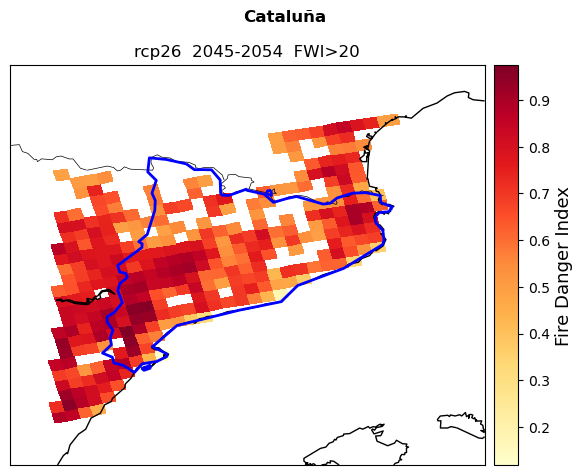

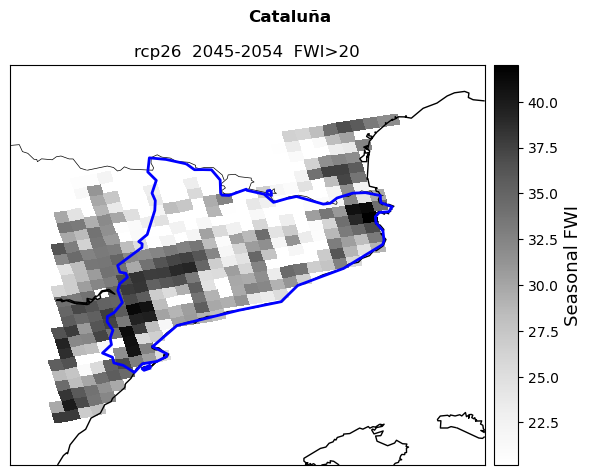

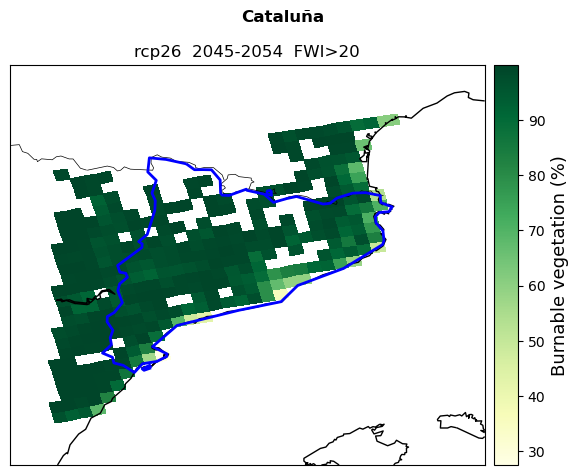

In [28]:
variables=[danger_index,clim_esa,burn_final]
labels=['Fire Danger Index', 'Seasonal FWI', 'Burnable vegetation (%)']
colors=['YlOrRd','Greys','YlGn']
name=['DangerInd','FWI','BurnVeg']

ystart=ds_FWI['time.year'][0].to_numpy() #identify the projection start year
yend=ds_FWI['time.year'][-1].to_numpy() #identify the projection end year
#zoom parameter
zoom=0.5 

#define the longitude and latitude coordinates
lon_plot=clim_danger['lon'].to_numpy()
lat_plot=clim_danger['lat'].to_numpy()

#plot 
for a,b in zip(variables,np.arange(len(variables))):
    map_FWI =Basemap(
                   resolution='i',
                   llcrnrlat=bbox[1]-zoom, urcrnrlat=bbox[3]+zoom,
                   llcrnrlon=bbox[0]-zoom, urcrnrlon=bbox[2]+zoom,
                   lon_0=bbox[1],lat_0=bbox[0])

    map_FWI.drawcoastlines()
    map_FWI.drawcountries()
    #map_FWI.contourf(lon_plot,lat_plot,danger_esa,cmap='Reds',zorder=1) 
    map_FWI.pcolormesh(lon_plot,lat_plot,a,cmap=colors[b],zorder=1) 
    map_FWI.colorbar().set_label(labels[b],fontsize=13)
    map_FWI.readshapefile(f'{data_dir}/{nuts_name}',nuts_name,color='b',linewidth=2) #draw region boundaries from shapefile
    plt.suptitle(str(nuts.iloc[0,4]),fontweight='bold') #title
    plt.title(rcp+' '+' '+str(ystart)+'-'+str(yend)+'  FWI>'+str(user_thresh))
    plt.tight_layout()
    plt.savefig(f'{results_dir}/'+str(nuts.iloc[0,4])+name[b]+'.png') #save plots in results directory
    plt.show()

## Vulnerability

The cells below download and extract vulnerability data from a series of datasets produced by the European Forest Fire Information Service [(EFFIS)](https://forest-fire.emergency.copernicus.eu/apps/fire.risk.viewer/). The extraction and reprojection procedure is the same as for the burnable vegetation. The processed vulnerability components will also be compiled to the risk dataset.

The chosen vulnerability indicators are:
- **Population** living in the **Wildland Urban Interface**, representing the share of total population living in the periurban areas bounding forested or vegetated areas
- **Protected Areas** distribution, representing the share of each pixel of the map covered by a protected natural area
- **Ecosystem Irreplaceability Index**, representing the uniqueness and inherent value of the ecosystems present in each pixel
- **Population Density**
- **Ecosystem Restoration Cost** Index, representing the relative restoration cost of land in case of loss by wildfire

The choice of vulnerability indicators follows the methodology of the latest EFFIS [Pan-European Wildfire Risk Assessment](https://publications.jrc.ec.europa.eu/repository/handle/JRC130136) (Jacome Felix Oom et al., 2022).

#### 1. Population at the Wildland Urban Interface (WUI)

In [ ]:
url = 'https://object-store.os-api.cci1.ecmwf.int/climaax/effis_mirror/var-WUI-prop_unit-dimensionless.tiff'
filename = 'var-WUI-prop_unit-dimensionless.tiff'
pooch.retrieve(
    url=url,fname=filename,
    known_hash='8c0a8a13151c4b1d812c59d9a450058c2e0c1aefd461648f0a05079c466b6346',
    path=data_dir)

In [ ]:
#open the dataset and apply the same preprocessing function used for the burnable area
wui_file=xr.open_mfdataset(f'{data_dir}/var-WUI-prop_unit-dimensionless.tiff',
                           preprocess=cut_to_region_EFFIS)

In [30]:
#Apply the extraction function
wui_final=extract_EFFIS(wui_file)
wui_final=wui_final*100 #convert to percentage

#Assign the result to the risk dataset
risk=risk.assign(wu_interf=wui_final)

#### 2. Protected areas fraction

In [ ]:
url = 'https://object-store.os-api.cci1.ecmwf.int/climaax/effis_mirror/var-PAF_unit-dimensionless.tiff'
filename = 'var-PAF_unit-dimensionless.tiff'
pooch.retrieve(
    url=url,fname=filename,
    known_hash='b17213da99dcb935c38d3b726a9a562ab1af3be058938b7de07f58bb0b860a36',
    path=data_dir)

In [31]:
prot_area_file=xr.open_mfdataset(f'{data_dir}/var-PAF_unit-dimensionless.tiff',
                           preprocess=cut_to_region_EFFIS)

In [32]:
#Apply the extraction function
prot_area_final=extract_EFFIS(prot_area_file)
prot_area_final=prot_area_final*100  #convert to percentage

#Assign to the risk dataset
risk=risk.assign(prot_area=prot_area_final)

#### 3. Ecosystems Irreplaceability

In [ ]:
url = 'https://object-store.os-api.cci1.ecmwf.int/climaax/effis_mirror/var-Irr_unit-dimensionless.tiff'
filename = 'var-Irr_unit-dimensionless.tiff'
pooch.retrieve(
    url=url,fname=filename,
    known_hash='99f7a29c8098658f9f7ffb85158b0c96cc9030e842642c2d1e66a84699eeae14',
    path=data_dir)

In [33]:
irrep_file=xr.open_mfdataset(f'{data_dir}/var-Irr_unit-dimensionless.tiff',
                           preprocess=cut_to_region_EFFIS)

In [34]:
#Apply the extraction function
irrep_final=extract_EFFIS(irrep_file)

#Assign to the risk dataset
risk=risk.assign(ecol_irrep=irrep_final)

#### 4. Population density

In [ ]:
url = 'https://object-store.os-api.cci1.ecmwf.int/climaax/effis_mirror/var-pop_unit-people-per-km2.tiff'
filename = 'var-pop_unit-people-per-km2.tiff'
pooch.retrieve(
    url=url,fname=filename,
    known_hash='069a345182b14e23f2035407b4123828a92c024dd00b5629379ae0d23008e877',
    path=data_dir)

In [35]:
pop_file=xr.open_mfdataset(f'{data_dir}/var-pop_unit-people-per-km2.tiff',
                           preprocess=cut_to_region_EFFIS)

In [36]:
#Apply the extraction function
pop_final=extract_EFFIS(pop_file)

#Assign to the risk dataset
risk=risk.assign(pop_dens=pop_final)

#### 5. Restoration cost

In [ ]:
url = 'https://object-store.os-api.cci1.ecmwf.int/climaax/effis_mirror/var-vuln-econ_unit-dimensionless.tiff'
filename = 'var-vuln-econ_unit-dimensionless.tiff'
pooch.retrieve(
    url=url,fname=filename,
    known_hash='044c03392da32e690cdfd3bd8d12652f30f4344c81cdc412f235753323cb969d',
    path=data_dir)

In [37]:
cost_file=xr.open_mfdataset(f'{data_dir}/var-vuln-econ_unit-dimensionless.tiff',
                           preprocess=cut_to_region_EFFIS)

In [38]:
#Apply the extraction function
cost_final=extract_EFFIS(cost_file)

#Assign to the risk dataset
risk=risk.assign(restor_cost=cost_final)

### Plot vulnerability indicators

Plot all the extracted vulnerability variables and save them in the results directory.

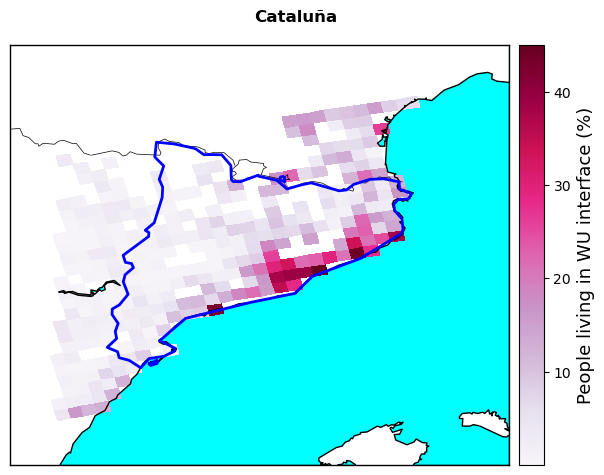

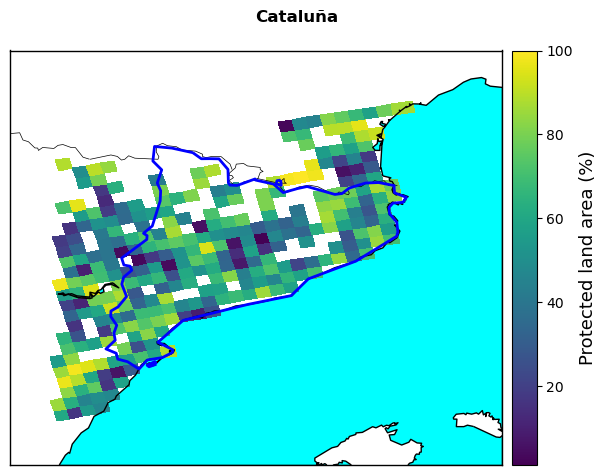

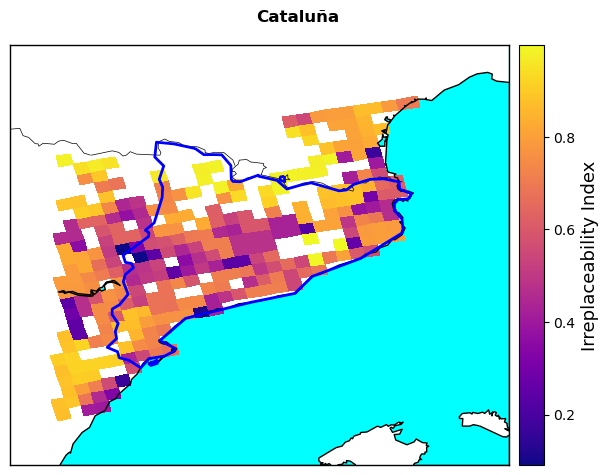

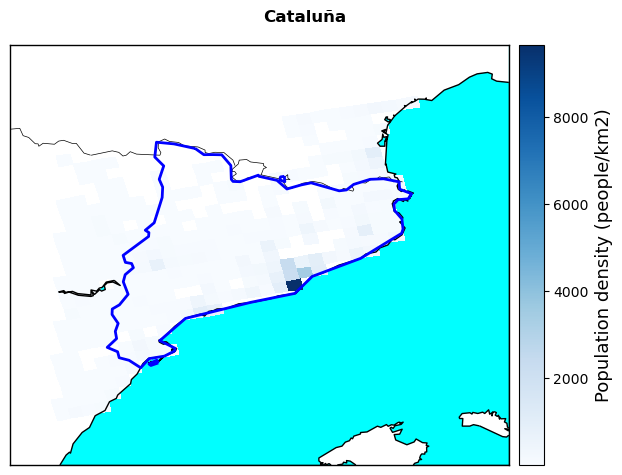

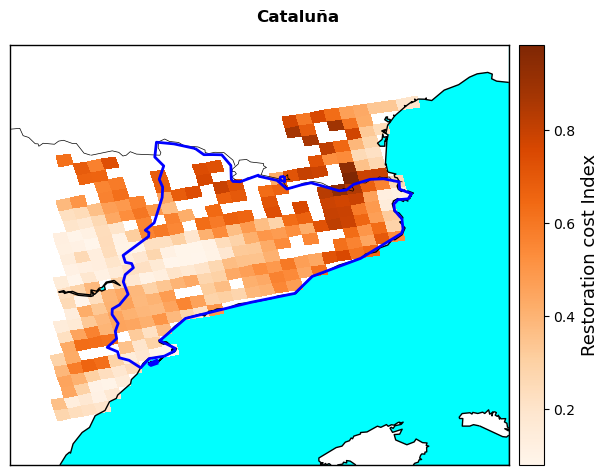

In [40]:
variables=[wui_final,prot_area_final,irrep_final,pop_final,cost_final]
colors=['PuRd','viridis','plasma','Blues','Oranges']
labels=['People living in WU interface (%)','Protected land area (%)',
       'Irreplaceability Index','Population density (people/km2)','Restoration cost Index']
outp_name=['Wui','ProtArea','Irrep','PopDens','RestCost']

zoom=0.5 

#define the longitude and latitude coordinates
lon_plot=clim_esa['lon'].to_numpy()
lat_plot=clim_esa['lat'].to_numpy()

for i,a in zip(variables,np.arange(len(variables))):
    map_FWI =Basemap(
                   resolution='i',
                   llcrnrlat=bbox[1]-zoom, urcrnrlat=bbox[3]+zoom,
                   llcrnrlon=bbox[0]-zoom, urcrnrlon=bbox[2]+zoom,
                   lon_0=bbox[1],lat_0=bbox[0])

    map_FWI.drawcoastlines()
    map_FWI.drawmapboundary(fill_color='aqua') 
    map_FWI.fillcontinents(color='white',lake_color='aqua')
    map_FWI.drawcountries()
    map_FWI.pcolormesh(lon_plot,lat_plot,i,cmap=colors[a],zorder=1)
    map_FWI.colorbar().set_label(labels[a] ,fontsize=13)
    map_FWI.readshapefile(f'{data_dir}/{nuts_name}',nuts_name,color='b',linewidth=2) #draw region boundaries from shapefile
    plt.suptitle(str(nuts.iloc[0,4]),fontweight='bold') #title
    plt.tight_layout()
    plt.savefig(f'{results_dir}/'+str(nuts.iloc[0,4])+outp_name[a]+'.png') #save plots in results directory
    plt.show()

In [41]:
#Display the final risk Dataarray
risk

<xarray.Dataset> Size: 74kB
Dimensions:       (rlon: 32, rlat: 24)
Coordinates:
  * rlon          (rlon) float64 256B -14.07 -13.96 -13.86 ... -10.77 -10.55
  * rlat          (rlat) float64 192B -8.965 -8.855 -8.745 ... -6.545 -6.435
    rotated_pole  |S1 1B b''
    lon           (rlat, rlon) float64 6kB -0.2876 -0.15 -0.01225 ... 3.226 3.52
    lat           (rlat, rlon) float64 6kB 40.04 40.07 40.1 ... 43.24 43.28
    time          datetime64[ns] 8B 2022-01-01
    spatial_ref   int32 4B 0
    x             (rlat, rlon) float64 6kB -0.2876 -0.15 -0.01225 ... 3.226 3.52
    y             (rlat, rlon) float64 6kB 40.04 40.07 40.1 ... 43.24 43.28
Data variables:
    clim_danger   (rlat, rlon) float64 6kB dask.array<chunksize=(24, 32), meta=np.ndarray>
    burn_area     (rlat, rlon) float64 6kB dask.array<chunksize=(24, 32), meta=np.ndarray>
    dg_index      (rlat, rlon) float64 6kB dask.array<chunksize=(24, 32), meta=np.ndarray>
    wu_interf     (rlat, rlon) float64 6kB dask.array<chunksize=(24, 32), meta=np.ndarray>
    prot_area     (rlat, rlon) float64 6kB dask.array<chunksize=(24, 32), meta=np.ndarray>
    ecol_irrep    (rlat, rlon) float64 6kB dask.array<chunksize=(24, 32), meta=np.ndarray>
    pop_dens      (rlat, rlon) float64 6kB dask.array<chunksize=(24, 32), meta=np.ndarray>
    restor_cost   (rlat, rlon) float64 6kB dask.array<chunksize=(24, 32), meta=np.ndarray>

## Pareto analysis of risk

After extracting the vulnerability indicators, these need to be combined among them and with the danger indicators to assess which areas of the region have the highest (or lowest) overall risk. To produce a uniform ranking of risk considering all the different indicators, a dedicated module is used to find the "Pareto front" of risk (see the [Risk description](FWI_Risk_Description.md) document for more info). In summary, the Pareto front represents the group of pixels having the highest risk profile assuming that all factors considered in the analysis equally contribute to wildfire risk. 

:::{important} Changing the factors considered in the Pareto analysis, the result changes. Thus, users can decide to include or exclude any vulnerability parameters in the analysis if they want to focus on a specific risk. For instance, if they wanted to focus on the risk to natural habitats they could consider only the fraction of protected area and the irreplaceability index as the vulnerability terms. In this way, the result will be the group of pixels having the highest "ecological risk". **N.B.** You should **always keep the danger** component in the Pareto analysis, as this represents the baseline for which risk itself develops.

:::{tip}
The Pareto analysis method allows users to introduce any additional vulnerability parameter not yet included in the assessment. If the additional vulnerability data are in the same .tiff format as the EFFIS data, users can follow the same import and extraction process to use them in the assessment (i.e., copy the import and extraction cells and change the file names).

For the Pareto analysis we are using the [paretoset](https://pypi.org/project/paretoset/) module, which needs data in [pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) format to operate. The module does not handle missing values, so we need to replace them with 0.

In [42]:
#Convert the risk DataArray to a pandas DataFrame, fill missing values with 0.
risk_df=risk.to_dataframe().fillna(0)

In the cell below, specify which variables you would like to include in the analysis. Here all the vulnerability variables but population density are selected. The names of the variables are those assigned to the risk datset.

In [43]:
variables_list=['dg_index','wu_interf','prot_area','ecol_irrep','restor_cost']

The cell below performs the Pareto analysis to identify the pixels with the highest and lowest risk. For the highest risk, the module is set to look for the "max" of each indicator across the region since all indicators are directly correlated with risk. The opposite applies when the lowest risk is calculated. 

If you would like to add a parameter that is inversely correlated with wildfire risk, such as the distribution of fire fighters, this parameter would need to be ranked as "min" for the highest risk calculation and as "max" for the lowest risk.

In [44]:
#Pixels with highest risk
paret_max=paretoset(risk_df[variables_list],sense=[max,max,max,max,max]) #find index of highest vuln pixels
max_pareto=risk_df[paret_max].to_xarray() #apply index to dataframe and convert back to xarray
max_pareto_sorted=max_pareto.sortby('rlon') #sort pixels (needed for plotting)
rmax=max_pareto_sorted['dg_index'] #select any of the variables (needed for plotting)

#Pixels with lowest risk
paret_min=paretoset(risk_df[variables_list],sense=[min,min,min,min,min]) #find index of lowest vuln pixels
min_pareto=risk_df[paret_min].to_xarray() #apply index to dataframe and convert back to xarray
min_pareto_sorted=min_pareto.sortby('rlon') #sort pixels (needed for plotting)
rmin=min_pareto_sorted['dg_index'] #select any of the variables (needed for plotting)

### Plot wildfire risk
The cell below plots the results of the risk analysis combining them with the danger dataset. The resulting plot gives an indication of the areas across the region with the highest wildfire risk and how this compares with the climatic danger represented by the FWI. Since the assessment is based on FWI data with 11x11 km resolution, the identified highest-risk areas also have this spatial resolution. 

Below the risk plot, an interactive map helps you visualising wildfire risk in the geographical context of the region. Zooming in the map the size of the red dots decreases as well. The location of the dots is not indicative of the exact location of the highest wildfire risk, but as shown in the risk map above, it indicates the centre of a 11x11 km radius where highest risk is found.

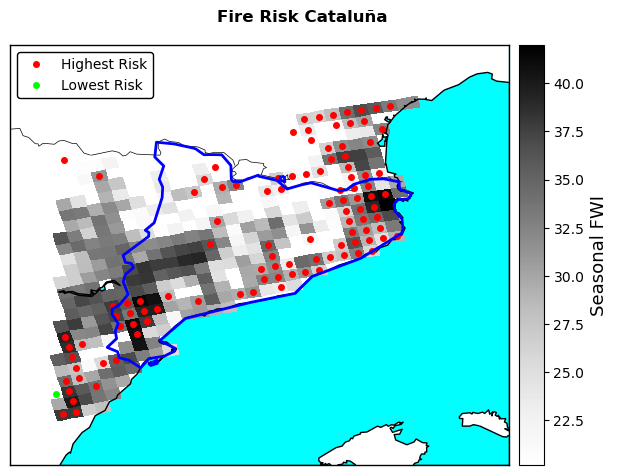

In [47]:
#zoom parameter
zoom=0.5 

#define the longitude and latitude coordinates
lon_plot=clim_esa['lon'].to_numpy()
lat_plot=clim_esa['lat'].to_numpy()

lon_max=max_pareto_sorted['lon'].squeeze()
lat_max=max_pareto_sorted['lat'].squeeze()

lon_min=min_pareto_sorted['lon'].squeeze()
lat_min=min_pareto_sorted['lat'].squeeze()


#set up the map and background colors
map_FWI =Basemap(
               resolution='i',
               llcrnrlat=bbox[1]-zoom, urcrnrlat=bbox[3]+zoom,
               llcrnrlon=bbox[0]-zoom, urcrnrlon=bbox[2]+zoom,
               lon_0=bbox[1],lat_0=bbox[0])

map_FWI.drawcoastlines()
map_FWI.drawmapboundary(fill_color='aqua') #make sea blue 
map_FWI.fillcontinents(color='white',lake_color='aqua') #make land white, lakes blue
map_FWI.drawcountries()

#plot the danger dataset as a grey raster, the highest risk points in red, the lowest in green.
map_FWI.pcolormesh(lon_plot,lat_plot,clim_esa,cmap='Greys') 
map_FWI.plot(lon_max,lat_max,rmax,marker='.',markersize=8,linestyle='None',color='r',label='Highest Risk') 
map_FWI.plot(lon_min,lat_min,rmin,marker='.',markersize=8,linestyle='None',color='lime',label='Lowest Risk') 
map_FWI.readshapefile(f'{data_dir}/{nuts_name}',nuts_name,color='b',linewidth=2) #draw region boundaries from shapefile

#set the colorbar, title and legend
map_FWI.colorbar().set_label('Seasonal FWI',fontsize=13)
plt.suptitle('Fire Risk '+str(nuts.iloc[0,4]),fontweight='bold') #title
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(),loc='best',edgecolor ='k',framealpha=1)
plt.tight_layout()

#save plots in results directory
plt.savefig(f'{results_dir}/'+str(nuts.iloc[0,4])+'_FireRisk.png') #save plots in results directory
plt.show()

In [ ]:
#Plot results on geographical map
plt.plot(lon_max.fillna(np.nanmean(lon_max)),lat_max.fillna(np.nanmean(lat_max)),'.',color='r',markersize=11) 
plt.plot(lon_min.fillna(np.nanmean(lon_min)),lat_min.fillna(np.nanmean(lat_min)),'.',color='lime',markersize=11) 
mplleaflet.display()

## Interpretation and Conclusions

The plot highlights which areas in the region have the highest wildfire risk given the specified vulnerability parameters. All the pixels with a red dot have an equally high risk profile, as they score equally high in different vulnerability indicators that have been selected here. In most cases the highest risk is observed in areas with the highest wildfire danger, here represented by the seasonal FWI (grey pixels). However, this is not always the case, with several pixels in the centre-west part of Catalunya not appearing among those with the highest fire risk profile depsite having relatively high FWI values. Once again, this discrepancy shows how wildfire risk, and climate-related risks in general, do not depend on a single factor but from the interplay between the natural (danger) and human (vulnerability) dimensions.

The map above can help regional authorities understanding where wildfire risk might be the highest, guiding them towards an effective planning and allocation of resources for wildfire risk adaptation. By customising the vulnerability indicators considered in the Pareto analysis, users can produce different maps according to the most relevant type of risk or to compare how different risks are spread across the regional territory. Being based on continental-scale datasets, this map might not have the resolution nor the accuracy to be fully consistent with real-world conditions. Thus, we advise to compare the present results with local expertise to double check the robustness of the assessment and to replace, whenever possible, the datasets used here with local, higher-reosolution equivalents to increase the accuracy of the reuslts. Users are also invited to add other danger and vulnerability components to the assessment to make it more comprehensive and aligned with local conditions. In this sense, the structure of the workflow facilitates the addition of new components that can be simply added to the existing list before computing the Pareto analysis of risk.  

### Contributors
Euro-Mediterranean Centre on Climate Change (CMCC), Italy

Author of the workflow: Andrea Rivosecchi

### References
Jacome Felix Oom, D., De Rigo, D., Pfeiffer, H., Branco, A., Ferrari, D., Grecchi, R., Artes Vivancos, T., Durrant, T., Boca, R., Maianti, P., Libertà, G. and San-Miguel-Ayanz, J. (2022). Pan-European wildfire risk assessment, EUR 31160 EN, Publications Office of the European Union, Luxembourg, ISBN 978-92-76-55138-6, doi:10.2760/437309, JRC130136.

Jones, M. W., Abatzoglou, J. T., Veraverbeke, S., Andela, N., Lasslop, G., Forkel, M., et al. (2022). Global and regional trends and drivers of fire under climate change. Reviews of Geophysics, 60, e2020RG000726. https://doi.org/10.1029/2020RG000726

Lund, M. T., Nordling, K., Gjelsvik, A. B., & Samset, B. H. (2023). The influence of variability on fire weather conditions in high latitude regions under present and future global warming. Environmental Research Communications, 5(6), 065016. https://doi.org/10.1088/2515-7620/acdfad